##### Import

In [ ]:
import os
import sys
import warnings
import gc
from pathlib import Path

import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

#### Test on unseen data

In [ ]:
from pathlib import Path
import pandas as pd
from utils import rank_stocks_and_quantile

target = 'TARGET_ret_fwd_frac_order'
top = 250  
unseen_key = '/data/YEAR_20220803_20230803'
unseen_store_path = Path(f'data/{top}_unseen_dataset.h5')

# Load dataset and rank stocks
with pd.HDFStore(unseen_store_path) as store:
    dataset = store[unseen_key]
    dataset_ranked = rank_stocks_and_quantile(dataset, target)

# Localize datetime index if not already done
datetime_level = 0  # Assuming the datetime is the first level
if dataset_ranked.index.levels[datetime_level].tz is None:
    localized_level = dataset_ranked.index.levels[datetime_level].tz_localize('UTC')
    dataset_ranked.index = dataset_ranked.index.set_levels(localized_level, level=datetime_level)

# Get unique dates and sort them
unique_dates = dataset_ranked.index.get_level_values('date').unique().sort_values()

# Extract feature columns and label columns
features = [col for col in dataset_ranked.columns if col.startswith('FEATURE_')]
label_cols = [col for col in dataset_ranked.columns if col.startswith('TARGET_')]

# Adjust for the look-ahead gap and get test dates
look_ahead = 1
test_dates = unique_dates[-21*9:]

# Extract the test data subset
test_data = dataset_ranked[dataset_ranked.index.isin(test_dates, level='date')]

print(test_data.info())

In [ ]:
import lightgbm as lgb
import pandas as pd

def predict_and_format(model_path: str, \
                    test_data: pd.DataFrame, \
                    features: list, label: str) -> pd.DataFrame:
    """
    Load a LightGBM model from the specified path, make predictions on the test data, and format the results.

    Parameters:
    - model_path: Path to the saved LightGBM model.
    - test_data: Test dataframe containing features and labels.
    - features: List of feature column names.
    - label: Column name of the label.

    Returns:
    - preds: Formatted dataframe with predictions and selected feature data.
    """

    # Load the model
    best_model = lgb.Booster(model_file=model_path)

    # Extract features and labels
    test_features = test_data[features]
    test_labels = test_data[label]

    # Make predictions
    y_pred = best_model.predict(test_features)

    # Format the predictions dataframe
    preds = test_labels.reset_index(name='actual').assign(predicted=\
        y_pred).set_index(['date', 'ticker'])

    # Rename columns to add 'feature_' prefix
    cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
    new_col_names = ["FEATURE_" + col for col in cols_to_rename]
    rename_dict = dict(zip(cols_to_rename, new_col_names))

    test_data_renamed = test_data.rename(columns=rename_dict)

    # Join with selected feature data
    preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                      on=['ticker', 'date'], 
                                      how='left')

    # Filter columns of interest
    preds = preds[['date', 'ticker', 'actual', 'predicted'] + new_col_names].set_index(['ticker', 'date'])
    
    return preds

model_path = "/home/sayem/Desktop/Project/models/_data_YEAR_20200930_20220802_best_model.txt"
preds = predict_and_format(model_path, test_data, features, target)

In [ ]:
preds

In [ ]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [ ]:
# Calculate the mean and standard deviation of daily correlations
mean_daily_correlation = daily_correlations.mean()
std_daily_correlation = daily_correlations.std()

# Calculate Sharpe ratio for each date
papermill_era_scores = daily_sharpe_ratios = (daily_correlations - \
    mean_daily_correlation) / std_daily_correlation

papermill_era_scores_df = papermill_era_scores.to_frame()
papermill_era_scores_df.columns = papermill_era_scores_df.columns.astype(str)
sb.glue("papermill_era_scores", papermill_era_scores_df, display=True)

papermill_era_scores_list = papermill_era_scores.tolist()
sb.glue("papermill_era_scores", papermill_era_scores_list)


In [ ]:
# import matplotlib.pyplot as plt
# from pathlib import Path

# # Create a list of colors based on the sign of the Sharpe Ratios
# colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

# plt.figure(figsize=(12,6))
# daily_sharpe_ratios.plot(kind='bar', color=colors)
# plt.title('Daily Sharpe Ratios')
# plt.xlabel('Date')
# plt.ylabel('Sharpe Ratio')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.axhline(y=0, color='black', linestyle='-')  # Add horizontal line at y=0
# plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# # Define directory and clean up the dataset_key
# plot_dir = Path("plots")
# clean_dataset_key = dataset_key.replace("/", "_")

# # Create the plots directory if it doesn't exist
# plot_dir.mkdir(exist_ok=True)

# # Define the save path for the plot using the cleaned key
# plot_path = plot_dir / f"sharpe_ratios_{clean_dataset_key}.png"

# # Save the plot
# plt.savefig(plot_path)
# plt.close()

# # Convert the path to string and glue it
# papermill_plot_path_str = str(plot_path)
# sb.glue("papermill_plot_path", papermill_plot_path_str, display=True)

In [ ]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

In [ ]:
preds.info()


In [ ]:
def add_quantile_signals(df, buy_threshold=0.95, sell_threshold=0.05):
    buy_cutoff = df['predicted'].quantile(buy_threshold)
    sell_cutoff = df['predicted'].quantile(sell_threshold)
    
    df['signal'] = 0  # Neutral by default
    df.loc[df['predicted'] >= buy_cutoff, 'signal'] = 1  # Buy
    df.loc[df['predicted'] <= sell_cutoff, 'signal'] = -1  # Sell
    return df

# Apply the function
preds = add_quantile_signals(preds, \
    buy_threshold=0.95, sell_threshold=0.05)

In [ ]:
preds.info()

##### Backtesting

In [ ]:
import pandas as pd
import backtrader as bt
import backtrader.indicators as btind  # <-- NEW: For adding indicators
import backtrader.analyzers as btanalyzers
from pypfopt import EfficientFrontier, expected_returns, risk_models
import yfinance as yf

# Data Class for Predictions
class PandasPredictions(bt.feeds.PandasData):
    lines = ('signal',)
    params = (
        ('signal', -1),
        ('open', 'FEATURE_open'),
        ('high', 'FEATURE_high'),
        ('low', 'FEATURE_low'),
        ('close', 'FEATURE_close'),
        ('volume', 'FEATURE_volume')
    )

# Function to optimize weights using PyPortfolioOpt
def optimize_weights(datas):
    prices = {}
    
    for data in datas:
        s = pd.Series(data.close.array, index=data.datetime.array, name=data._name)
        prices[data._name] = s

    df = pd.DataFrame(index=prices[next(iter(prices))].index)

    for ticker, s in prices.items():
        df = df.merge(s, left_index=True, right_index=True, \
            how='left').rename(columns={s.name: ticker})

    df = df.dropna()

    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)
    ef = EfficientFrontier(mu, S, solver="SCS", verbose=True)
    weights = ef.max_sharpe(risk_free_rate=0.005)
    return ef.clean_weights()

# Strategy Class
class TradeAndRebalanceStrategy(bt.Strategy):
    lines = ('benchmark',)
    
    params = (
        ('stop_loss', 0.05),
        ('take_profit', 0.10),
        ('benchmark_MA_period', 21)  # <-- NEW: Moving Average period for the benchmark
    )
    
    def __init__(self):
        self.rebalance_days = 0
        self.max_loss = -0.15
        self.start_cash = self.broker.get_cash()
        self.benchmark_data = self.getdatabyname("S&P 500")
        self.benchmark_MA = btind.SimpleMovingAverage(self.benchmark_data, \
            period=self.params.benchmark_MA_period)
        self.orders = {}  # to store buy order references

    def log(self, txt, dt=None):
        ''' Logging function for the strategy. It logs the date and the message provided. '''
        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")

    def notify_order(self, order):
        # If an order is completed, remove it from the orders dict
        if order.status == order.Completed:
            if order.ref in self.orders:
                del self.orders[order.ref]

    def next(self):
        # Use the moving average of the benchmark for decisions
        if self.benchmark_data.close[0] > self.benchmark_MA[0]:  # Bullish scenario
            benchmark_trend = 1
        else:  # Bearish scenario
            benchmark_trend = -1
            
        self.log(f"Benchmark Trend: {'Bullish' if benchmark_trend == 1 else 'Bearish'}")

        benchmark_return = (self.benchmark_data.close[0] - \
            self.benchmark_data.close[-1]) / self.benchmark_data.close[-1]
        self.log(f"Benchmark Return: {benchmark_return * 100:.2f}%")

        if (self.broker.get_cash() - self.start_cash) / self.start_cash <= self.max_loss:
            return
        
        for data in self.datas:
            if data._name == "S&P 500":  # Skip the benchmark for trading signals
                continue

            # Making decisions based on benchmark's performance
            if benchmark_return > 0:  # Benchmark shows positive returns
                if data.signal[0] == 1:
                    order = self.buy(data)
                    self.orders[order.ref] = order
                    
                    # Setting stop-loss and take-profit levels
                    stop_price = data.close[0] * (1.0 - self.params.stop_loss)
                    limit_price = data.close[0] * (1.0 + self.params.take_profit)
                    
                    self.sell(data=data, exectype=bt.Order.Stop, price=stop_price, parent=order.ref)
                    self.sell(data=data, exectype=bt.Order.Limit, price=limit_price, parent=order.ref)
                    
            elif benchmark_return < 0:  # Benchmark shows negative returns
                self.sell(data)

        if self.rebalance_days == 0:
            weights = optimize_weights([data for data in self.datas if data._name != "S&P 500"])
            for asset, weight in weights.items():
                if weight > 0.30:
                    weights[asset] = 0.30
            
            for data in self.datas:
                if data._name == "S&P 500":
                    continue
                if data._name in weights:
                    self.order_target_percent(data, target=weights[data._name])
                else:
                    self.close(data)
            self.rebalance_days = 20
        else:
            self.rebalance_days -= 1


# Fetch S&P 500 data using yfinance
def fetch_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df

# Assume preds is defined somewhere earlier in your code
start_date = preds.index.get_level_values(1).min()
end_date = preds.index.get_level_values(1).max()
sp500_data = fetch_data('^GSPC', start_date, end_date)

# Convert it into Backtrader format
benchmark = bt.feeds.PandasData(dataname=sp500_data, name="S&P 500")

cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(btanalyzers.PyFolio, _name='pyfolio')
cerebro.adddata(benchmark)

your_data_dict = {ticker: preds.xs(ticker) for ticker in preds.index.get_level_values(0).unique()}
for ticker, data_df in your_data_dict.items():
    data = PandasPredictions(dataname=data_df, name=ticker)
    cerebro.adddata(data)

cerebro.addstrategy(TradeAndRebalanceStrategy)
results = cerebro.run()

# Performance Analysis
returns, positions, transactions, gross_lev \
    = results[0].analyzers.pyfolio.get_pf_items()

In [ ]:
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


# Assuming 'returns' contains the daily percentage returns of your strategy
# For example:
# returns = [0.01, -0.02, 0.015, ...]  # Replace this with your actual returns data

# Extend the Quantstats reports to consider the entire dataframe
qs.extend_pandas()

# # # # Print extended, in-depth performance stats
# qs.reports.full(returns)

# Print only the metrics
qs.reports.metrics(returns)

# # Plotting various graphs
# qs.plots.snapshot(returns, title='Performance Snapshot')  # Snapshot of the performance
# qs.plots.monthly_heatmap(returns)  # Monthly returns heatmap
# qs.plots.yearly_returns(returns)   # Yearly returns

# plt.show()


                           Strategy
-------------------------  ----------
Start Period               2022-11-01
End Period                 2023-08-03
Risk-Free Rate             0.0%
Time in Market             89.0%

Cumulative Return          12.72%
CAGR﹪                     11.6%

Sharpe                     1.18
Prob. Sharpe Ratio         84.51%
Smart Sharpe               1.11
Sortino                    1.77
Smart Sortino              1.67
Sortino/√2                 1.25
Smart Sortino/√2           1.18
Omega                      1.21

Max Drawdown               -7.63%
Longest DD Days            51
Volatility (ann.)          14.46%
Calmar                     1.52
Skew                       -0.03
Kurtosis                   0.13

Expected Daily %           0.06%
Expected Monthly %         1.2%
Expected Yearly %          6.17%
Kelly Criterion            8.86%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.43%
Expected Shortfall (cVaR)  -1.43%

Max Consecutive Wins       7
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-12-01,2022-12-19,2023-01-20,51,-7.629369,-7.317765
2,2023-02-16,2023-03-13,2023-03-30,43,-5.337832,-5.260617
3,2023-07-19,2023-08-03,2023-08-03,16,-4.454683,-4.136910
4,2023-05-19,2023-05-24,2023-06-14,27,-4.422829,-3.810016
5,2023-02-02,2023-02-10,2023-02-14,13,-2.444519,-1.976387


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


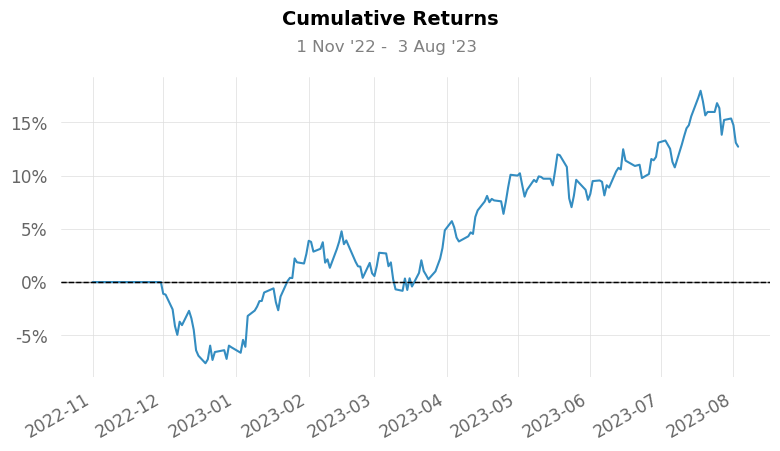

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


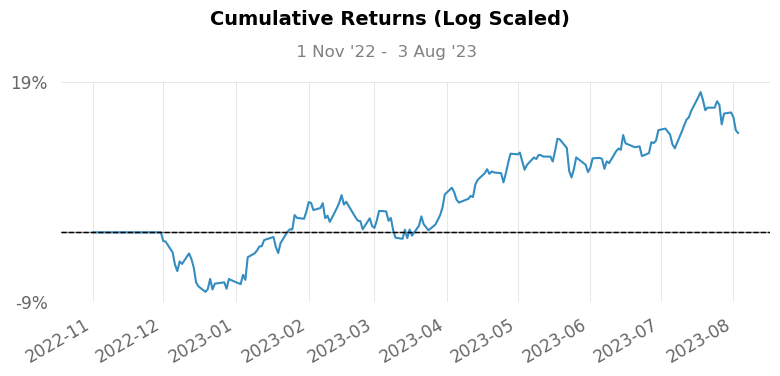

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


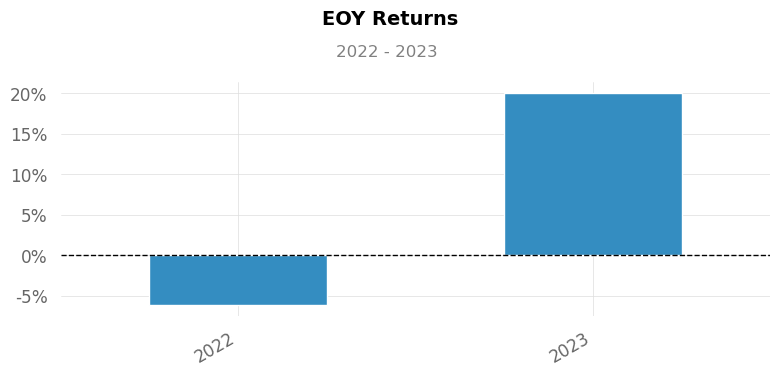

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


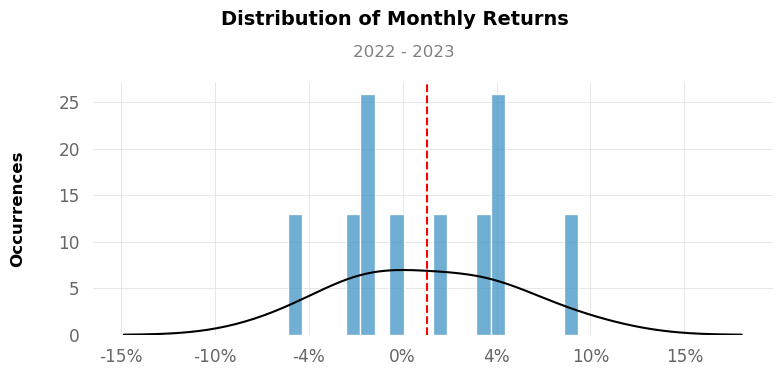

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


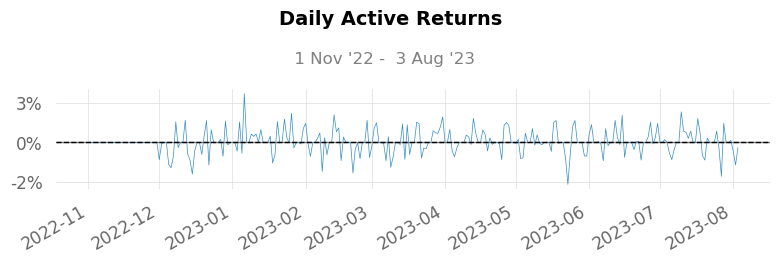

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


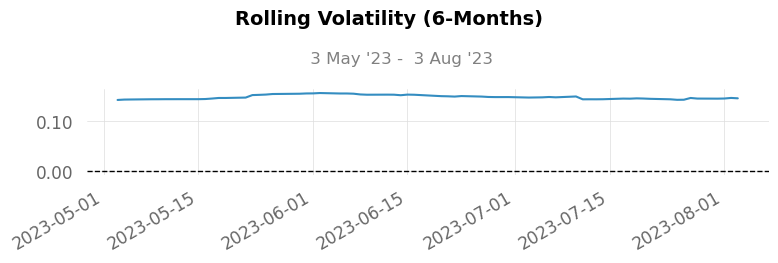

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


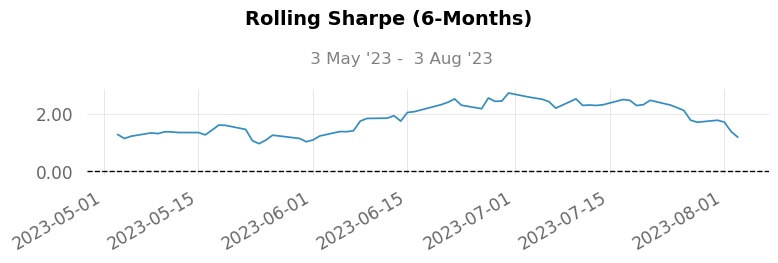

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


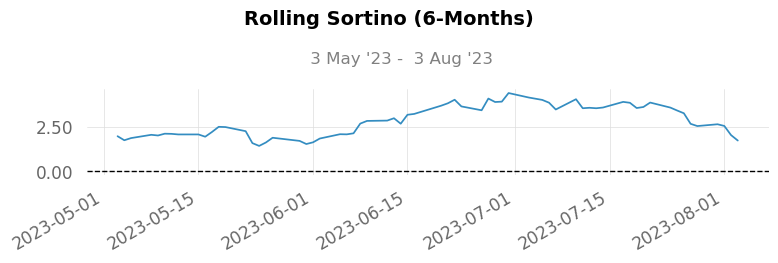

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


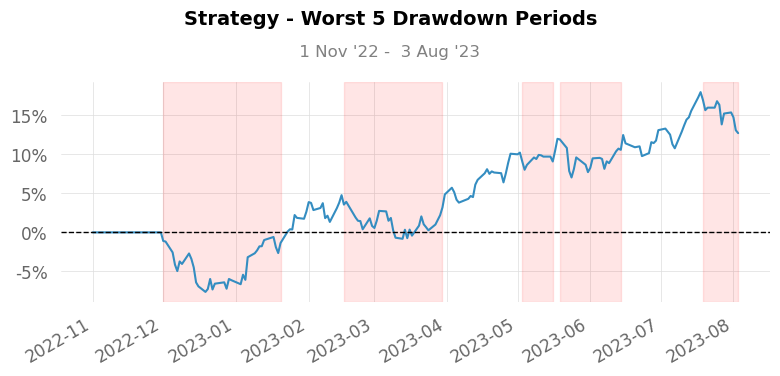

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


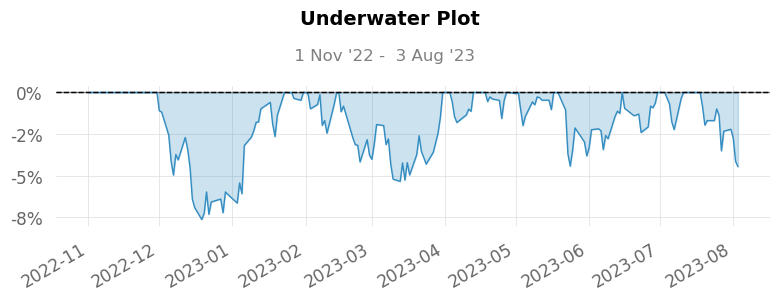

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


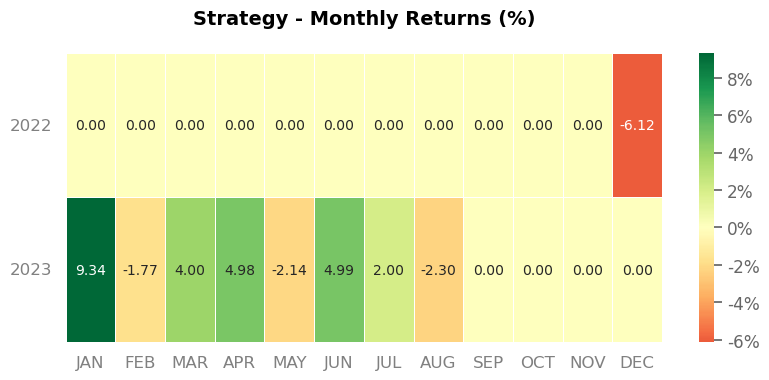

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


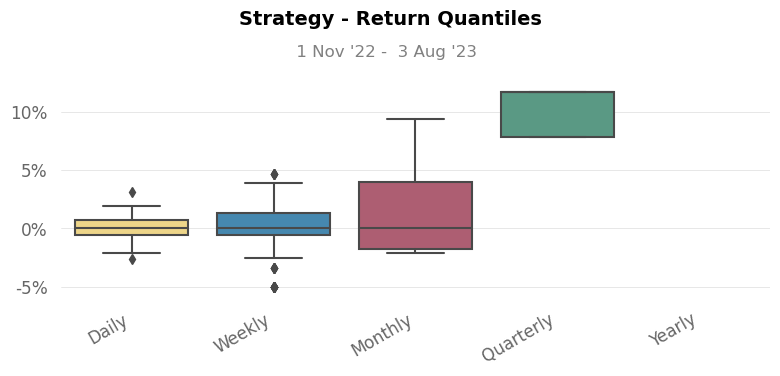

In [17]:
qs.reports.full(returns)
plt.show()